## EDA & Data Cleansing

### References: https://www.kaggle.com/code/jagangupta/stop-the-s-toxic-comments-eda

### Used the resource above as a baseline + Modified it so that it is compatiable with latest versions

#### In case of NLTK errors: <python -m nltk.downloader wordnet>

## Install required packages in the following cell before proceed

In [ ]:
import pandas as pd 
import numpy as np

import time
import warnings

import matplotlib.pyplot as plt

import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

import string
import re
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer

In [ ]:
!python -m nltk.downloader stopwords
!python -m nltk.downloader wordnet

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive_dir = '/content/drive/MyDrive/Colab Notebooks/2022 ML Proj/'

Mounted at /content/drive


## Modify the path with your own setting

In [ ]:
train_dir = drive_dir + "/jigsaw-toxic-comment-classification-challenge/train.csv/train.csv"
test_dir = drive_dir + "/jigsaw-toxic-comment-classification-challenge/test.csv/test.csv"
train=pd.read_csv(train_dir)
test=pd.read_csv(test_dir)

In [ ]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [ ]:
n_train = train.shape[0]
n_test = test.shape[0]
n_total = n_train + n_test
print("       | Train | Test")
print("count  :",n_train,":",n_test)
print("ratio  :", round(n_train * 100 / n_total),"   :",round(n_test * 100 / n_total))

       | Train | Test
count  : 159571 : 153164
ratio  : 51    : 49


In [ ]:
x = train.iloc[:, 2:].sum()
train['non-toxic'] = (train.iloc[:,2:].sum(axis=1)==0)
print("Total : ", len(train))
print("Total non-toxic comments : ", train['non-toxic'].sum())
print("Total labels : ", x.sum())

Total :  159571
Total non-toxic comments :  143346
Total labels :  35098


### Seems like we have a pretty biased dataset. We should keep it in mind when training.

In [ ]:
print('Check Null Values: ')
print(train.isnull().sum())

Check Null Values: 
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
non-toxic        0
dtype: int64


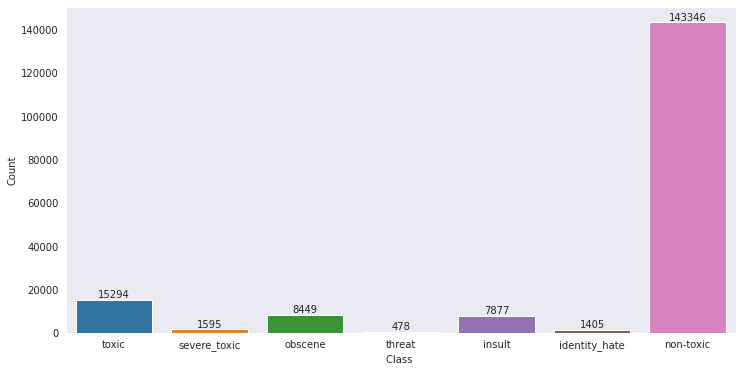

In [ ]:
x = train.iloc[:,2:].sum()
plt.figure(figsize=(12,6))
ax = sns.barplot(x = x.index, y = x.values)
plt.ylabel('Count', fontsize=10)
plt.xlabel('Class ', fontsize=10)
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

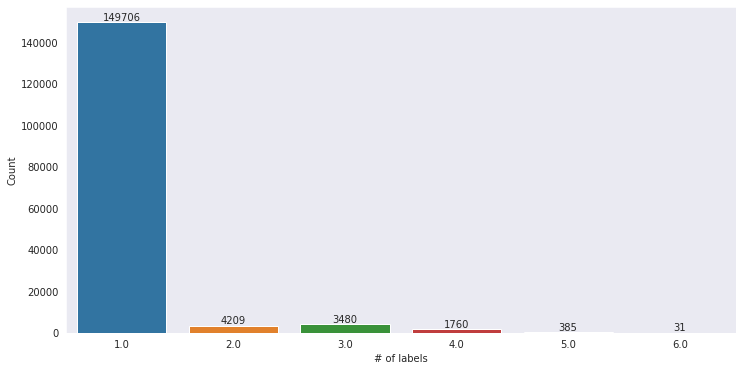

In [ ]:
x = train.iloc[:,2:].sum(axis=1).value_counts()

plt.figure(figsize=(12,6))
ax = sns.barplot(x = x.index, y = x.values)
plt.ylabel('Count', fontsize=10)
plt.xlabel('# of labels', fontsize=10)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

### Some datapoints have multiple tags.

In [ ]:
temp_df = train.iloc[:,2:-1]
mats = []
for col in temp_df.columns[1:]:
    mat = pd.crosstab(temp_df["toxic"], temp_df[col])
    mats.append(mat)
mats = pd.concat(mats, axis=1, keys=temp_df.columns[1:])
mats

severe_toxic       obscene        threat       insult        \
severe_toxic            0     1       0     1       0    1       0     1   
toxic                                                                      
0                  144277     0  143754   523  144248   29  143744   533   
1                   13699  1595    7368  7926   14845  449    7950  7344   

             identity_hate        
severe_toxic             0     1  
toxic                             
0                   144174   103  
1                    13992  1302

### Seems like toxic=0 even if a comment is obscene/threat/...
### Maybe we should apply toxic=1 if a comment is obscene/threat/...

In [ ]:
train.loc[(train['severe_toxic']==1) | (train['obscene']==1) | (train['threat']==1) | (train['insult']==1) | (train['identity_hate']==1), 'toxic']=1

In [ ]:
temp_df = train.iloc[:,2:-1]
mats = []
for col in temp_df.columns[1:]:
    mat = pd.crosstab(temp_df["toxic"], temp_df[col])
    mats.append(mat)
mats = pd.concat(mats, axis=1, keys=temp_df.columns[1:])
mats

severe_toxic       obscene        threat       insult        \
severe_toxic            0     1       0     1       0    1       0     1   
toxic                                                                      
0                  143346     0  143346     0  143346    0  143346     0   
1                   14630  1595    7776  8449   15747  478    8348  7877   

             identity_hate        
severe_toxic             0     1  
toxic                             
0                   143346     0  
1                    14820  1405

In [ ]:
print("toxic:")
print(train[train.severe_toxic==1].iloc[3,1])

toxic:
Hi 

Im a fucking bitch.

50.180.208.181


In [ ]:
print("severe_toxic:")
print(train[train.severe_toxic==1].iloc[4,1])

severe_toxic:
What a motherfucking piece of crap those fuckheads for blocking us!


In [ ]:
print("Threat:")
print(train[train.threat==1].iloc[1,1])

Threat:
I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms


In [ ]:
print("Obscene:")
print(train[train.obscene==1].iloc[1,1])

Obscene:
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!


In [ ]:
print("identity_hate:")
print(train[train.identity_hate==1].iloc[4,1])

identity_hate:
u r a tw@ fuck off u gay boy.U r smelly.Fuck ur mum poopie


In [ ]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.101679,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.302226,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
cols = ['obscene', 'insult', 'toxic', 'severe_toxic', 'identity_hate', 'threat']
print(train[cols].sum())

obscene           8449
insult            7877
toxic            16225
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


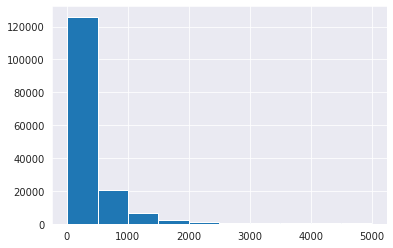

In [ ]:
train['length'] = train['comment_text'].apply(lambda x: len(str(x)))
train['length'].hist()
plt.show()

### Most of the text length are within 500 characters, with some up to 5,000 characters long.

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [ ]:
train['comment_text'] = train['comment_text'].map(lambda com : clean_text(com))
test['comment_text'] = test['comment_text'].map(lambda com : clean_text(com))

In [ ]:
train['comment_text'][1]

'd aww he matches this background colour i am seemingly stuck with thanks talk 21 51 january 11 2016 utc'

In [ ]:
train['comment_text'][10000]

'hi redrose and apologies for delay here is a draft of what i propose to present on the new section pages the 6 volumes of ultimate allocations cover the are ported allocations of all british railways steam diesel electric locomotives on br stock from 1950 1968 with additional information from 1948 where available they are formatted in a4 comb bound volumes for ease of use there are 3 main columns which are sub divided with individual locomotive details including date when new if appropriate all are ported and published allocations and re allocations combined with withdrawal dates where known are listed on either weekly monthly or period ending dependant on regional variations at that time a link to several testimonials and scanned images type of information provided can be found at www ultimate allocations co uk please advise if this information would be acceptable for presentation in the new section you previously advised i look forward to seeing your reply and thank you once again f

In [ ]:
train['comment_text'][100000]

'i think she meets notability guidelines and thanks for creating the page for her she was a big icon in the pageant drag community and in the drag gay community in general her death has been covered by several mainstream media outlets'

In [ ]:
train.head(20)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non-toxic,length
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,True,264
1,000103f0d9cfb60f,d aww he matches this background colour i am s...,0,0,0,0,0,0,True,112
2,000113f07ec002fd,hey man i am really not trying to edit war it ...,0,0,0,0,0,0,True,233
3,0001b41b1c6bb37e,more i cannot make any real suggestions on imp...,0,0,0,0,0,0,True,622
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,True,67
5,00025465d4725e87,congratulations from me as well use the tools ...,0,0,0,0,0,0,True,65
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1,1,1,0,1,0,False,44
7,00031b1e95af7921,your vandalism to the matt shirvington article...,0,0,0,0,0,0,True,115
8,00037261f536c51d,sorry if the word nonsense was offensive to yo...,0,0,0,0,0,0,True,472
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,True,70


In [ ]:
test.head(20)

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule is more succesful then you wi...
1,0000247867823ef7,from rfc the title is fine as it is imo
2,00013b17ad220c46,sources zawe ashton on lapland
3,00017563c3f7919a,if you have a look back at the source the info...
4,00017695ad8997eb,i do not anonymously edit articles at all
5,0001ea8717f6de06,thank you for understanding i think very highl...
6,00024115d4cbde0f,please do not add nonsense to wikipedia such e...
7,000247e83dcc1211,dear god this site is horrible
8,00025358d4737918,only a fool can believe in such numbers the co...
9,00026d1092fe71cc,double redirects when fixing double redirects ...


## Until here what we did: EDA + Cleansing text

## Using Bert
Reference: https://www.tensorflow.org/text/tutorials/classify_text_with_bert#choose_a_bert_model_to_fine-tune


In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 4.9 MB 5.3 MB/s 
     |████████████████████████████████| 497.9 MB 27 kB/s 
     |████████████████████████████████| 1.4 MB 77.0 MB/s 
     |████████████████████████████████| 5.8 MB 80.8 MB/s 
     |████████████████████████████████| 462 kB 90.5 MB/s 
     |████████████████████████████████| 1.8 MB 5.0 MB/s 
     |████████████████████████████████| 238 kB 86.7 MB/s 
     |████████████████████████████████| 352 kB 81.8 MB/s 
     |████████████████████████████████| 1.1 MB 82.0 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 99 kB 11.5 MB/s 
     |████████████████████████████████| 116 kB 76.4 MB/s 
     |████████████████████████████████| 1.3 MB 78.4 MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

tf.get_logger().setLevel('ERROR')

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42
buffer_size = 512

In [ ]:
train = train[['comment_text', 'toxic']]
test = test[['id', 'comment_text']]

In [ ]:
train['toxic'].values

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
thresh = len(train) // 5 * 4
train, val = train.iloc[:thresh, :], train.iloc[thresh:, :]

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((tf.cast(train['comment_text'].values, tf.string),
                                              tf.cast(train['toxic'].values, tf.int32))).shuffle(buffer_size, seed=seed).batch(batch_size)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((tf.cast(val['comment_text'].values, tf.string),
                                              tf.cast(val['toxic'].values, tf.int32))).shuffle(buffer_size, seed=seed).batch(batch_size)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for text, label in train_ds.take(1):
    print(text)
    print(label)

tf.Tensor(
[b'image popclassic jpg i have tagged image popclassic jpg as because it does not provide a fair use rationale if you believe the image to be acceptable for fair use according to wikipedia policy please provide a rationale explaining as much in accordance with the fair use rationale guideline on the image description page please also consider using or one of the other tags listed at wikipedia image copyright tags fair_use thank you man'
 b'i think that your a fagget get a oife and burn in hell i hate you m sorry we cant have any more sex i am running out of conndoms'
 b'i am afraid that a broken link for me'
 b'what is up with this if you are a religiously or politically motivated to push this or that issue please refrain from talking on my page i am not interested otherwise feel free to talk about relevant edits here or science deleet talk i would prefer if the following users never post here maunus \xca\x8daunus snun\xc9\x90w weijibaikebianji this guy is a published psycho

In [ ]:
#@title
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
print('Input Comment: ', train.iloc[0]['comment_text'])
text_test = [train.iloc[0]['comment_text']]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :128]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :128]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :128]}')

Input Comment:  explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now 89 205 38 27
Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  7526  2339  1996 10086  2015  2081  2104  2026  5310 18442 13076
 12392  2050  5470  2020 16407  2027  2020  2025  3158  9305 22556  2074
  8503  2006  2070  3806  2044  1045  5444  2012  2047  2259 14421  6904
  2278  1998  3531  2079  2025  6366  1996 23561  2013  1996  2831  3931
  2144  1045  2572  3394  2085  6486 16327  4229  2676   102     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[-0.46918002  0.9723433  -0.23389442  0.1490449   0.83817947  0.5412565
  0.95891076 -0.99924433 -0.66763616 -0.9098855   0.30295658 -0.9009653 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.14740038 -0.58563113  0.76476216 ... -0.51163816 -0.6755288
   0.02217148]
 [-1.4931933  -0.03775471 -0.60175085 ... -0.15824434  0.3693566
   1.4564564 ]
 [-1.1276897  -0.30858868  0.31846786 ... -0.92985135 -1.3447778
   0.9644512 ]
 ...
 [-1.6901499   0.66192865 -0.7176934  ... -0.8555795   0.42925692
  -0.14999703]
 [-0.9823128  -0.22795296 -0.19410776 ... -0.82550406 -1.3430405
  -0.4241021 ]
 [-1.0308168   0.05774682  0.53512025 ... -0.8283109   0.0666419
  -0.72816193]]


In [ ]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.47964662]], shape=(1, 1), dtype=float32)


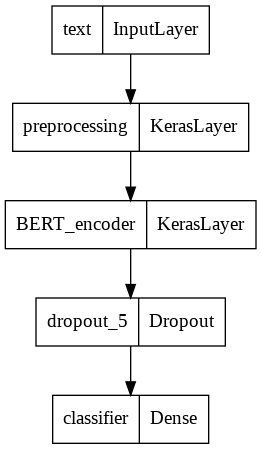

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

# Low-level training loop

In [ ]:
# loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# train_acc_metric = tf.metrics.BinaryAccuracy()
# val_acc_metric = tf.metrics.BinaryAccuracy()
# optimizer = tf.keras.optimizers.Adam(lr=3e-5)

In [ ]:
# @tf.function
# def train_step(x, y):
#     with tf.GradientTape() as tape:
#         logits = classifier_model(x, training=True)
#         loss_value = loss_fn(y, logits)
#     grads = tape.gradient(loss_value, classifier_model.trainable_weights)
#     optimizer.apply_gradients(zip(grads, classifier_model.trainable_weights))
#     train_acc_metric.update_state(y, logits)
#     return loss_value

In [ ]:
# @tf.function
# def test_step(x, y):
#     val_logits = classifier_model(x, training=False)
#     val_acc_metric.update_state(y, val_logits)

In [ ]:
# epochs = 5
# for epoch in range(epochs):
#     print("\nStart of epoch %d" % (epoch,))
#     start_time = time.time()

#     # Iterate over the batches of the dataset.
#     for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
#         loss_value = train_step(x_batch_train, y_batch_train)

#         # # Log every 200 batches.
#         # if step % 200 == 0:
#         #     print(
#         #         "Training loss (for one batch) at step %d: %.4f"
#         #         % (step, float(loss_value))
#         #     )
#         #     print("Seen so far: %d samples" % ((step + 1) * batch_size))

#     # Display metrics at the end of each epoch.
#     train_acc = train_acc_metric.result()
#     print("Training acc over epoch: %.4f" % (float(train_acc),))

#     # Reset training metrics at the end of each epoch
#     train_acc_metric.reset_states()

#     # Run a validation loop at the end of each epoch.
#     for x_batch_val, y_batch_val in val_ds:
#         test_step(x_batch_val, y_batch_val)

#     val_acc = val_acc_metric.result()
#     val_acc_metric.reset_states()
#     print("Validation acc: %.4f" % (float(val_acc),))
#     print("Time taken: %.2fs" % (time.time() - start_time))

# Class Weights to deal with imbalance

In [ ]:
neg, pos = np.bincount(train['toxic'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 127656
    Positive: 13000 (10.18% of total)



In [ ]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.56
Weight for class 1: 4.91


In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 1e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               class_weight=class_weight)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
3990/3990 [==============================] - 323s 79ms/step - loss: 0.3143 - binary_accuracy: 0.9337 - val_loss: 0.1797 - val_binary_accuracy: 0.9429
Epoch 2/5
3990/3990 [==============================] - 316s 79ms/step - loss: 0.2203 - binary_accuracy: 0.9623 - val_loss: 0.1862 - val_binary_accuracy: 0.9459
Epoch 3/5
3990/3990 [==============================] - 316s 79ms/step - loss: 0.1983 - binary_accuracy: 0.9694 - val_loss: 0.1654 - val_binary_accuracy: 0.9554
Epoch 4/5
3990/3990 [==============================] - 316s 79ms/step - loss: 0.1822 - binary_accuracy: 0.9734 - val_loss: 0.1646 - val_binary_accuracy: 0.9574
Epoch 5/5
3990/3990 [==============================] - 316s 79ms/step - loss: 0.1700 - binary_accuracy: 0.9769 - val_loss: 0.1465 - val_binary_accuracy: 0.9627


In [ ]:
loss, accuracy = classifier_model.evaluate(val_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

998/998 [==============================] - 48s 48ms/step - loss: 0.1465 - binary_accuracy: 0.9627
Loss: 0.14652501046657562
Accuracy: 0.9626507759094238


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


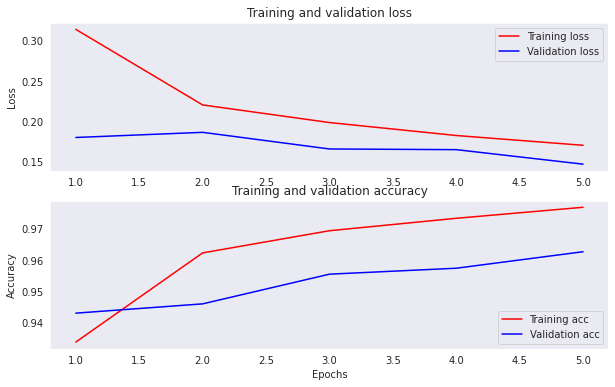

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'toxic'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path)

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()

examples = [
    'I like the weather today',
    'What do you want from me?',
    'Fuxk damn shit',
    'What the fuck is wrong with U?',
    'Your grandma wouldve done better than you',
    'this is fukcing great!!!',
]

examples = [clean_text(example) for example in examples]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: i like the weather today       : score: 0.000639
input: what do you want from me       : score: 0.014509
input: fuxk damn shit                 : score: 0.999832
input: what the fuck is wrong with u  : score: 0.999790
input: your grandma wouldve done better than you : score: 0.187312
input: this is fukcing great          : score: 0.000686

Results from the model in memory:
input: i like the weather today       : score: 0.000639
input: what do you want from me       : score: 0.014509
input: fuxk damn shit                 : score: 0.999832
input: what the fuck is wrong with u  : score: 0.999790
input: your grandma wouldve done better than you : score: 0.187312
input: this is fukcing great          : score: 0.000686



In [ ]:
dataset_name = 'toxic'
saved_model_path = drive_dir + '/{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path)

# Evaluation

In [ ]:
logits = classifier_model.predict(val['comment_text'])
probs = np.squeeze(np.array(tf.sigmoid(logits)))
predictions = (probs > .5).astype(int)

In [ ]:
labels = val['toxic']

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, roc_curve, RocCurveDisplay

In [ ]:
fpr, tpr, _ = roc_curve(labels, probs)
roc_auc = metrics.auc(fpr, tpr)

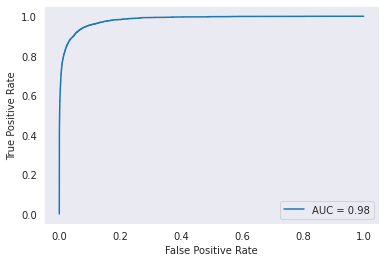

In [ ]:
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()

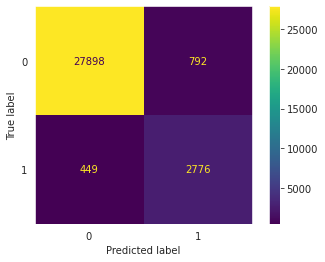

In [ ]:
cm = confusion_matrix(labels, predictions)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()
plt.show()

In [ ]:
print('Validation Accuracy: ', round(accuracy_score(labels, predictions)*100, 2), '%')

Validation Accuracy:  96.11 %


In [ ]:
print('Validation F1-Score: ', round(f1_score(labels, predictions)*100, 2), '%')

Validation F1-Score:  81.73 %


In [ ]:
'''
Things to consider

(V) 0. Evaluation Score
- F1, Confusion Matrix, Accuracy, ROC, AUC

(V) 1. Class Imbalance
- Non toxic >>> Toxic
- Custom training loop with re-sampling to deal with imbalance
- Or, using class weights

(V) 2. Excluding Stopwords 
- only first 128 words can be handled with the above Bert

3. Extra inputs
- length of sentence
- number of large letters (should be examined first)

4. Unsupervised
- pre-trained embedding vs fin-tuned embedding (k = 2)

5. Identifying important words with TF-IDF


'''

'\nThings to consider\n\n(V) 0. Evaluation Score\n- F1, Confusion Matrix, Accuracy, ROC, AUC\n\n(V) 1. Class Imbalance\n- Non toxic >>> Toxic\n- Custom training loop with re-sampling to deal with imbalance\n- Or, using class weights\n\n(V) 2. Excluding Stopwords \n- only first 128 words can be handled with the above Bert\n\n3. Extra inputs\n- length of sentence\n- number of large letters (should be examined first)\n\n4. Unsupervised\n- pre-trained embedding vs fin-tuned embedding (k = 2)\n\n5. Identifying important words with TF-IDF\n\n\n'